#### List of problems:
[Task 1](#Task1) 20 points

[Task 2](#Task2) 15 points

[Task 3](#Task3) 5 points 

[Task 4](#Task4) 10 points 

------ Total : 50 points  -------

[Bonus](#Bonus) 10 point

## Variational Autoencoders

VAEs consider two-step generative process by a prior over latent space $p(z)$ and a conditional generative distribution $p_{\theta}(x|z)$, which is parametrized by a deep neural network (DNN). Our goal is to maximize marginal log-likehood  which is intractable in general case. Therefore, variational inference (VI) framework is considered.

\begin{equation*}
    \begin{aligned}
    & \log p(x) \geq \mathcal{L}(x;\theta;q) = \mathbb{E}_{z\sim q(z)}[\log p_{\theta}(x|z)] - \text{KL}[q(z)\|p(z)],
    \end{aligned}
\end{equation*}

where $q(z|x)$ is a variational posterior distribution. Given data distribution $p_e(x) = \frac1N\sum_{i=1}^N \delta_{x_i}(x)$ we aim at maximizing the average marginal log-likelihood. Following the variational auto-encoder architecture amortized inference is proposed by choice of the variational distribution $q_{\phi}(z|x)$ which is also parametrized by DNN.

\begin{equation*}
    \begin{aligned}
    & \arg\max\limits_{\phi, \theta}\mathbb{E}_{x}\mathcal{L}(x,\phi,\theta)=\arg\max\limits_{\phi, \theta}\mathbb{E}_{x}\mathbb{E}_{z\sim q(z)}[\log p_{\theta}(x|z)] - \mathbb{E}_x \text{KL}[q_{\phi}(z|x)\|p(z)].
    \end{aligned}
\end{equation*}

To evaluate the performance of the VAE approach, we will estimate a negative log likelihood (NLL) on the test set. NLL is calculated by importance sampling method:
\begin{equation*}
   - \log p(x) \approx - \log \frac{1}{K} 
   \sum_{i = 1}^K \frac{p_\theta(x | z_i) p(z_i)}{q_\phi(z_i | x)},\,\,\,\,z_i \sim q_\phi(z | x).     
\end{equation*}

### References
1. Auto-Encoding Variational Bayes https://arxiv.org/pdf/1312.6114.pdf
2. Beta-VAE https://pdfs.semanticscholar.org/a902/26c41b79f8b06007609f39f82757073641e2.pdf
3. Importance Weighted Autoencoders https://arxiv.org/pdf/1509.00519.pdf 

## VAE
Below you can find empty class for VAE model. It contians methods, which will help you to make all the tasks in this aasignment. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import math 
def log_gaussian(x, mean, logvar, dim=None):
    log_normal = -0.5 * (math.log(2.0*math.pi) + logvar + 
                         torch.pow(x - mean, 2) / (logvar.exp()+1e-5))
    return log_normal.sum(dim)

In [3]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

from collections import OrderedDict

encode_block = lambda i, o: nn.Sequential(
    nn.Conv2d(i, o, kernel_size=5, padding=0),
    nn.ELU(),
    nn.MaxPool2d(5)
)

decoder_block = lambda i, o, k, s, p, a, op: nn.Sequential(
    nn.ConvTranspose2d(i, o, k, s, p, output_padding=op),
    nn.ELU() if a else nn.Identity()
)

class VAE(nn.Module):
    def __init__(self, hid_dim):
        """
        z_dim: int, dimention of the latent space
        x_dim: int, input image will have size (3, x_dim, x_dim)
        """
        super(VAE, self).__init__()
        self.hid_dim = hid_dim
        # Initialize Encoder and Decoder networks
        
        self.encoder = nn.Sequential(OrderedDict([
            ('encode1', encode_block(3, 16)),    # N x 16 x 12 x 12
            ('flatten', nn.Flatten(start_dim=1)),
            ('elr', nn.Linear(16 * 12 * 12, self.hid_dim)),
        ]))

        self.mu = nn.Linear(self.hid_dim, self.hid_dim)
        self.logvar = nn.Linear(self.hid_dim, self.hid_dim)

        self.decoder = nn.Sequential(OrderedDict([
            ('dlr', nn.Linear(self.hid_dim, 16 * 12 * 12)),
            ('unflatten', nn.Unflatten(1, (16, 12, 12))),
            ('upsample', nn.Upsample(size=(64, 64))),
            ('decode3', decoder_block(16, 3, 1, 1, 0, True, 0)),
        ]))
       
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_normal_(m.weight.data)
        
    def q_z(self, x):
        """
        VARIATIONAL POSTERIOR
        :param x: input image
        :return: parameters of q(z|x), (MB, hid_dim)
        """
        ## YOUR CODE HERE
        z = self.encoder(x)
        z_mean = self.mu(z)
        z_logvar = self.logvar(z)
        return Normal(z_mean, z_logvar)

    def p_x(self, z):
        """
        GENERATIVE DISTRIBUTION
        :param z: latent vector          (MB, hid_dim)
        :return: parameters of p(x|z)    (MB, inp_dim)
        """
        ## YOUR CODE HERE
        x = self.decoder(z)
        return x

    def forward(self, x):
        """
        Encoder the image, sample z and decode 
        :param x: input image
        :return: parameters of p(x|z_hat), z_hat, parameters of q(z|x)
        """
        # YOUR CODE HERE
        x_encoded = self.encoder(x)
        z_mu, z_logvar = self.mu(x_encoded), self.logvar(x_encoded)
        z_sample = self.reparametrize(z_mu, z_logvar)
        x_mu = self.decoder(z_mu)
        x_logvar = self.decoder(z_logvar)
        return x_mu, x_logvar, z_sample, z_mu, z_logvar

    def log_p_z(self, z):
        """
        Log density of the Prior
        :param z: latent vector     (MB, hid_dim)
        :return: \sum_i log p(z_i)  (1, )
        """
        # YOUR CODE HERE
        return torch.log(z).sum()

    def reconstruct_x(self, x):
        x_mean, _, _, _, _ = self.forward(x)
        return x_mean

    def kl(self, z, z_mean, z_logvar):
        """
        KL-divergence between p(z) and q(z|x)
        :param z:                               (MB, hid_dim)
        :param z_mean: mean of q(z|x)           (MB, hid_dim)
        :param z_logvar: log variance of q(z|x) (MB, hid_dim)
        :return: KL                             (MB, )
        """
        # YOUR CODE 
        '''
        x_recon = self.decoder
        p = Normal(torch.zeros_like(z_mean), torch.ones_like(z_logvar))
        q = Normal(z_mean, z_logvar.mul(0.5).exp_())
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
        '''
        return -0.5 * torch.mean(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())

    def calculate_loss(self, x, beta=1.):
        """
        Given the input batch, compute the negative ELBO 
        :param x:   (MB, inp_dim)
        :param beta: Float
        :return: nll + beta * KL  (MB, ) or (1, )
        """
        # YOUR CODE HERE

    def calculate_nll(self, X, K=100):
        """
        Estimate NLL by importance sampling 
        (see VAE seminar, but be carefull with dimetions)
        :param X: dataset, (N, 3, w, h)
        :param samples: Samples per observation
        :return: IS estimate
        """
        # YOUR CODE HERE       
        X_encoded = self.encoder(X)
        Z_mean, Z_logvar = self.mu(X_encoded), self.logvar(X_encoded)
        p = Normal(torch.zeros_like(z_mean), torch.ones_like(z_logvar))
        q = Normal(z_mean, z_logvar.mul(0.5).exp_())
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

    def generate_x(self, N=25):
        """
        Sample, using you VAE: sample z from prior and decode it 
        :param N: number of samples
        :return: X (N, inp_size)
        """
        # YOUR CODE HERE

    @staticmethod
    def reparametrize(mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(mu.device)
        return eps.mul(std).add_(mu)

## Generalization

The size of the Dataset, that is used to train generative model is often exponentially small compared to the support of density $p(x)$. Thus, it is important to be able to evaluate genralization abilities of the learned model.

In this assignment you will be asked to evaluate generalization ability of the VAE, using the approach discussed in https://arxiv.org/abs/1811.03259. 

Authors propose to study the generalization ability of the generative model, using **probing features** - functions which map image to a value. E.g., number of objects on the images.


We will use the dataset with dots, which can be downloaded [here](https://drive.google.com/open?id=1CsDMOIGEsD1l3BLhuQDfEfEmLEb83wMz). 

---
<a id='Task1'></a>
**Task 1. [20 pts]: Training**
* Train your VAE on the **subset** of images contating only 3 dots (use batch 0-5 for training and leave 6 and 7 for validation). 
* Plot ELBO vs Iteration, KL vs Iteration and NLL vs Iteration during training.
* Plot 10 pairs of `image`-`reconstruction` for 10 random images from the validation dataset 
* Plot 10 samples from the model

Note, that the task is considered completed only if your model produces reasonable **reconstructions** and **samples**. By resonable I mean:
- Reconstructions and true images have the same number of dots of similar colors
- Samples have dots of different colors on them (they may not have perfect shapes)

---
Some hints, that might be usefull (you do not have to use all of them):
- Use CNNs for encoder and decoder
- Use gaussian distribution for $p(x|z)$
- **Fix** variance of the $p(x|z)$ and train only mean value (aka NLL is MSE loss)
- Scale pixels of the input (dataset) and output (generated) images to [-1,1] range
- Use `Upsample` + `Conv` instead of `ConvTranspose` in the decoder
- Use $\beta$-VAE objective instead of simple ELBO:
    $$ -NLL + \beta \text{KL}(q(z|x)\|p(z))$$
$\beta$ is a hyperparameter. You can either fix it, or use so-called $\beta$-annealing. In the latter case, we gradually increase the value of $\beta$ from 0 during training.
- If reconstructions look nice but samples are bad, you probably need to put more weight on the KL-term  (larger $\beta$)

+ other standard DL tricks, e.g. lr annealing, early stopping, augmentations, etc.
---

In [4]:
# Load the data, define train and validation datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np

class DotsDataset(Dataset):
    def __init__(self, data_dir, file_numbers, transform=None):
        self.images = torch.zeros(0, 3, 64, 64)
        for file_number in file_numbers:
            batch = np.load(f'{data_dir}batch{file_number}.npz')
            batch = torch.tensor(batch['images']).permute(0, 3, 1, 2)
            self.images = torch.cat((self.images, batch))

    def __getitem__(self, i):
        return self.images[i]

    def __len__(self):
        return len(self.images)


In [5]:
data_dir = '/content/gdrive/My Drive/Colab Notebooks/pr3/vae model and generalization/dots/3_dots/'

train_dataset = DotsDataset(data_dir, list(range(6)))
val_dataset = DotsDataset(data_dir, list(range(6, 8)))

BATCH_SIZE = 2
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                             num_workers=2, pin_memory=True)


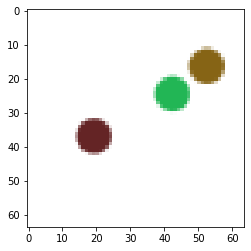

In [6]:
import matplotlib.pyplot as plt
import random

plt.imshow(train_dataset[random.randrange(len(train_dataset))].permute(1, 2, 0))


In [7]:
# Training VAE (do not forget to save checkpoint, 
# and send it along with HW solution)

import torch.nn.functional as F


def eval_elbo(X, vae):
  """
  Compute reconstruction loss and KL term for a given mini-batch
  """
  # YOUR CODE HERE

  # encode X
  z = vae.encoder(X)
  z_mu, z_logvar = vae.mu(z), vae.logvar(z)
  
  # compute KL
  kl = vae.kl(z, z_mu, z_logvar)

  # sample z from var posterior
  z_sample = vae.reparametrize(z_mu, z_logvar)
  
  # decode z
  X_recon = vae.decoder(z_sample)
  rec_loss = F.binary_cross_entropy(X_recon, X, size_average=False)
  
  return rec_loss.mean(), kl.mean()


def train_vae(train_loader, max_epoch, vae):
  kl_hist = []
  rec_hist = []
  all_params = vae.parameters()
  optim = torch.optim.Adam(all_params, lr=1e-4)
  for e in range(max_epoch):
    tot_rec = 0.
    tot_kl = 0.
    for X in train_loader:
      optim.zero_grad()
      X = X.to(device)
      rec_loss, kl = eval_elbo(X, vae)
      loss = rec_loss + kl #* alpha
      loss.backward()
      optim.step()

      tot_rec += rec_loss.item() / len(train_loader)
      tot_kl += kl.item() / len(train_loader)
      # YOUR CODE HERE
      


    kl_hist.append(tot_kl)
    rec_hist.append(tot_rec)
    fig, ax = plt.subplots(ncols=2, figsize=(10,5))
    ax[0].plot(kl_hist)
    ax[0].set_title('kl')
    ax[0].set_yscale('log')
    ax[1].plot(rec_hist)
    ax[1].set_title('rec')
    ax[1].set_yscale('log')
    plt.pause(0.3);
    clear_output(wait=True);


In [8]:
device = 'cuda'
vae = VAE(32)
vae.to(device)

VAE(
  (encoder): Sequential(
    (encode1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): ELU(alpha=1.0)
      (2): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (elr): Linear(in_features=2304, out_features=32, bias=True)
  )
  (mu): Linear(in_features=32, out_features=32, bias=True)
  (logvar): Linear(in_features=32, out_features=32, bias=True)
  (decoder): Sequential(
    (dlr): Linear(in_features=32, out_features=2304, bias=True)
    (unflatten): Unflatten(dim=1, unflattened_size=(16, 12, 12))
    (upsample): Upsample(size=(64, 64), mode=nearest)
    (decode3): Sequential(
      (0): ConvTranspose2d(16, 3, kernel_size=(1, 1), stride=(1, 1))
      (1): ELU(alpha=1.0)
    )
  )
)

In [142]:
dilation=1
H_in, kernel_size, stride, padding, output_padding = 66, 1, 1, 1, 0


(H_in - 1)*stride - 2*padding + dilation*(kernel_size - 1) + output_padding



63

In [12]:
train_vae(train_dataloader, 20, vae)

RuntimeError: ignored

In [ ]:
# Plot reconstructions

---
<a id='Task2'></a>
**Task 2. [15 pts]: Evaluation**

Calculate NLL on a validation set, contating only 3 dots. 

In [ ]:
# your code here

---
<a id='Task2'></a>
**Task 3. [5 pts]: Generalization [1]**

* Sample 25 images from the VAE and draw them on the 5 $\times$ 5 grid. 
* What can you say abuout generalization ability of the model based the results

In [ ]:
# Sampling

# your code here

`comment`

--- 
<a id='Task4'></a>
**Task 4. [10 pts]: Generalization [2]** 

* Define 2 new validation sets: containing only 2 dots (batches 6 and 7) and only 4 dots (batches 6-7) 
* Plot reconstruction of 10 random from both dataset
* Compute NLL of your VAE on these datasets
* What can you say abuout generalization ability of the model based the results


In [ ]:
# NLL for 5 dots per image

# your code here

In [ ]:
`comment`

---
<a id='Bonus'></a>
## Bonus task [10 pts]

Assume that we want to quantify the generalization ability of the model. To do that, we need to accurately compute number of dots on all the generated images.

1. Train neural network, which will classify images based on number of dots with high probability (>95%)
2. Generate 10'000 images from you VAE
3. Classify generated images and plot the histogram

In [ ]:
# your code here